In [1]:
import os

import keras.src.utils

fname = os.path.join('../data/climate.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

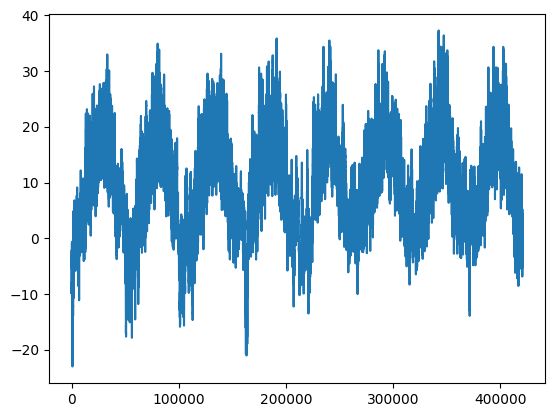

In [3]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)
plt.show()

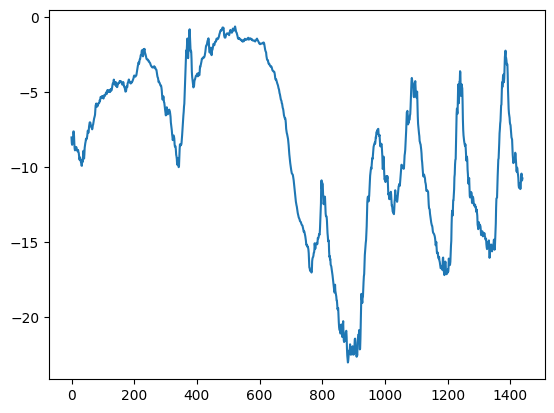

In [4]:
plt.plot(range(1440), temperature[:1440])
plt.show()

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print('num_train_samples : ', num_train_samples)
print('num_val_samples : ', num_val_samples)
print('num_test_samples : ', num_test_samples)

num_train_samples :  210225
num_val_samples :  105112
num_test_samples :  105114


In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [12]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [13]:
for samples, targets in train_dataset:
    print('샘플 크기 : ', samples.shape)
    print('타깃 크기 : ', targets.shape)
    break

샘플 크기 :  (256, 120, 14)
타깃 크기 :  (256,)


In [17]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

2024-08-20 14:53:46.534830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


검증 MAE: 2.44
테스트 MAE: 2.62


2024-08-20 14:53:49.177966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2024-08-20 14:44:59.776028: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2024-08-20 14:44:59.776084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
	 [[{{function_node __inference_one_step_on_data_9950}}{{node functional_1/flatten_1/Reshape}}]]


InvalidArgumentError: Graph execution error:

Detected at node functional_1/flatten_1/Reshape defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/anaconda3/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/opt/anaconda3/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/opt/anaconda3/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/3g/9z2y6vy916ncn7tzc7rkg8140000gn/T/ipykernel_49244/3649754642.py", line 14, in <module>

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py", line 175, in call

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py", line 556, in call

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py", line 54, in call

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 4440, in reshape

  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 1789, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node functional_1/flatten_1/Reshape}}]] [Op:__inference_one_step_on_iterator_9983]

In [11]:
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint(filepath="jena_conv.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f'테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 30.6737 - mae: 4.2605 - val_loss: 16.1262 - val_mae: 3.1974
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 16.2578 - mae: 3.2031 - val_loss: 15.1622 - val_mae: 3.0803
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 14.5250 - mae: 3.0166 - val_loss: 16.6555 - val_mae: 3.1900
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 13.4127 - mae: 2.8972 - val_loss: 14.5308 - val_mae: 2.9915
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 12.7835 - mae: 2.8245 - val_loss: 17.2077 - val_mae: 3.2232
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 12.2771 - mae: 2.7659 - val_loss: 14.6412 - val_mae: 2.9942
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 11.8106 - mae: 2.7111 - val_loss: 16.0241 - val_mae: 3.1682
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 11.4515 - mae: 2.6669 - val_loss: 14.3519 - val_mae: 2.9749
Epoch 9/10
819/819 ━━━━━

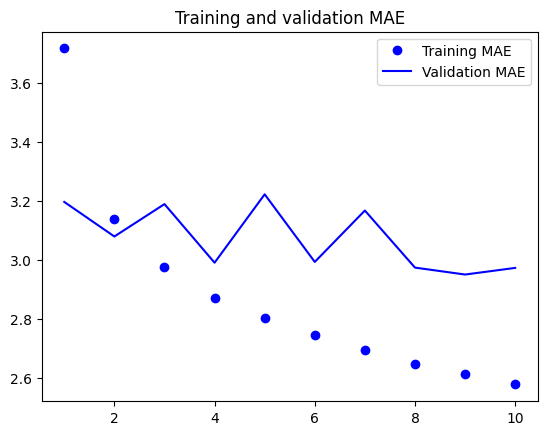

In [19]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint(filepath="jena_lstm.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f'테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 30s 36ms/step - loss: 72.8124 - mae: 6.5175 - val_loss: 12.6157 - val_mae: 2.6962
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - loss: 12.1033 - mae: 2.6873 - val_loss: 9.8967 - val_mae: 2.4476
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 10.0152 - mae: 2.4620 - val_loss: 10.1020 - val_mae: 2.4759
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 9.6009 - mae: 2.4056 - val_loss: 9.9704 - val_mae: 2.4367
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 9.3570 - mae: 2.3696 - val_loss: 10.0093 - val_mae: 2.4467
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 9.0731 - mae: 2.3323 - val_loss: 10.0741 - val_mae: 2.4492
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 8.8905 - mae: 2.3074 - val_loss: 10.7442 - val_mae: 2.5214
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 8.6890 - mae: 2.2800 - val_loss: 10.9007 - val_mae: 2.5248
Epoch 9/10
819/819 ━━━━━━━━━━━━

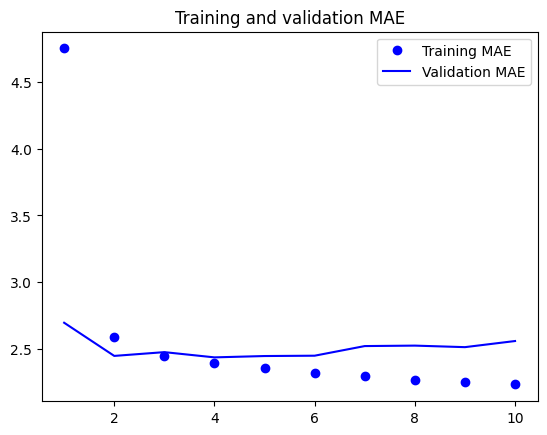

In [21]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [22]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [23]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [24]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [25]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [26]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(1)(x)

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint(filepath="jena_lstm_dropout.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 58s 70ms/step - loss: 50.3328 - mae: 5.2869 - val_loss: 9.7634 - val_mae: 2.4344
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - loss: 15.3549 - mae: 3.0494 - val_loss: 9.1625 - val_mae: 2.3580
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 14.5656 - mae: 2.9650 - val_loss: 9.1290 - val_mae: 2.3500
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - loss: 13.9921 - mae: 2.9074 - val_loss: 9.1297 - val_mae: 2.3480
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - loss: 13.6360 - mae: 2.8656 - val_loss: 9.0164 - val_mae: 2.3289
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - loss: 13.3388 - mae: 2.8366 - val_loss: 8.9733 - val_mae: 2.3269
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - loss: 13.0849 - mae: 2.8086 - val_loss: 8.9259 - val_mae: 2.3208
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 62s 76ms/step - loss: 12.7734 - mae: 2.7773 - val_loss: 8.8042 - val_mae: 2.3054
Epoch 9/10
819/819 ━━━━━━━━━━━━━

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint(filepath="jena_stacked_gru_dropout.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f'테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 167ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 169ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 128s 157ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 136s 165ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 171ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 175ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 152s 185ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 148s 181ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/1

ValueError: File not found: filepath=jena_stacked_gru_dropout.keras. Please ensure the file is an accessible `.keras` zip file.

In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 63s 75ms/step - loss: 48.4929 - mae: 5.0999 - val_loss: 10.5099 - val_mae: 2.5271
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 62s 75ms/step - loss: 9.8458 - mae: 2.4504 - val_loss: 10.4252 - val_mae: 2.5042
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - loss: 8.7306 - mae: 2.2993 - val_loss: 10.4204 - val_mae: 2.5184
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 63s 77ms/step - loss: 8.1326 - mae: 2.2214 - val_loss: 11.0898 - val_mae: 2.5860
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 64s 78ms/step - loss: 7.7415 - mae: 2.1707 - val_loss: 10.9178 - val_mae: 2.5782
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 68s 82ms/step - loss: 7.3589 - mae: 2.1193 - val_loss: 11.7714 - val_mae: 2.6499
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 70s 85ms/step - loss: 7.0335 - mae: 2.0703 - val_loss: 11.1726 - val_mae: 2.6004
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 80ms/step - loss: 6.7830 - mae: 2.0349 - val_loss: 11.7574 - val_mae: 2.6631
Epoch 9/10
819/819 ━━━━━━━━━━━━